In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np

def load_depth_csv(path: Path, depth_scale: float = 0.001) -> np.ndarray:
    """
    CSV形式の深度画像を読み込み，メートル[m]単位に変換して返す関数

    Parameters
    ----------
    path : Path
        深度CSVファイルへのパス
    depth_scale : float
        元の値に掛けるスケール係数
        例）RealSenseのuint16[mm]なら 0.001 を掛けて[m]にする

    Returns
    -------
    depth_m : np.ndarray
        深度[m]（0以下はNaNで無効扱い）
    """
    # CSVを読み込み（float32に変換）
    d = np.loadtxt(path, delimiter=",").astype(np.float32)
    # 0以下の値は無効値としてNaNにしてお
    d[d <= 0] = np.nan
    # スケールを掛けて[m]に変換
    return d * depth_scale

def depth_to_colormap(depth_m: np.ndarray, near: float | None = None, far: float | None = None):
    """
    深度[m]画像をヒートマップ（BGRカラー）に変換する関数

    Parameters
    ----------
    depth_m : np.ndarray
        深度[m]（NaNは無効値）
    near : float | None
        カラーマップに使う手前側の距離[m]
        Noneなら有効画素の5パーセンタイルから自動推定
    far : float | None
        カラーマップに使う奥側の距離[m]
        Noneなら有効画素の95パーセンタイルから自動推定

    Returns
    -------
    depth_cmap : np.ndarray
        COLORMAP_JETでカラー化したBGR画像
    near : float
        実際に使用したnear値
    far : float
        実際に使用したfar値
    """

    # 有効な深度値（NaN以外）だけ取得
    valid = depth_m[np.isfinite(depth_m)]

    # near / far が指定されていない場合は自動推定
    if near is None or far is None:
        if valid.size == 0:
            # すべて無効値だった場合のデフォルトレンジ
            near, far = 0.2, 1.0
        else:
            # 5〜95パーセンタイルをレンジにする
            near = float(np.percentile(valid, 5))
            far  = float(np.percentile(valid, 95))
            # near = far になってしまう場合の対策
            if near == far:
                near, far = max(near - 0.05, 0.05), near + 0.05
    
    # 深度を [0,1] に正規化した後，[0,255] のuint8にスケーリング
    x = np.clip((depth_m - near) / (far - near), 0, 1)
    vis = (x * 255).astype(np.uint8)

    # OpenCVのカラーマップでヒートマップ化（BGR）
    depth_cmap = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
    return depth_cmap, near, far

def show_overlay_inline(
    rgb_path: Path,
    depth_csv_path: Path,
    alpha: float = 0.,
    near: float | None = None,
    far: float | None = None,
    depth_scale: float = 0.001,
    save_dir: Path | None = None,
):
    """
    RGB画像と深度CSVを読み込み，ヒートマップとオーバーレイを
    Jupyter / Pythonスクリプト上で並べて表示する関数

    Parameters
    ----------
    rgb_path : Path
        RGB画像（BGRとして読み込む）のパス
    depth_csv_path : Path
        深度CSVファイルのパス
    alpha : float
        オーバーレイ時の深度ヒートマップの透過率（0〜1）
    near, far : float | None
        深度レンジ[m]。Noneなら自動推定
    depth_scale : float
        CSVの値 → [m] へのスケール係数
    save_dir : Path | None
        画像保存先ディレクトリ（Noneなら保存しない）

    Returns
    -------
    overlay : np.ndarray
        BGRのオーバーレイ画像
    depth_cmap : np.ndarray
        深度ヒートマップ（BGR）
    near_used : float
        使用したnear値
    far_used : float
        使用したfar値
    saved : dict
        保存したパス（"overlay", "panel", "depth_colormap"）を格納
    """

    # --- RGB画像読み込み（BGRとしてロード） ---
    color = cv2.imread(str(rgb_path))
    if color is None:
        raise FileNotFoundError(f"Could not read RGB image: {rgb_path}")

    # --- 深度CSV読み込み＆[m]変換 ---
    depth_m = load_depth_csv(depth_csv_path, depth_scale=depth_scale)

    # --- 解像度チェック（RGBと深度のサイズが一致しているか） ---
    if (color.shape[0], color.shape[1]) != depth_m.shape:
        raise ValueError(f"Size mismatch: RGB {color.shape[:2]} vs Depth {depth_m.shape}")

    # --- 深度をヒートマップ化 ---
    depth_cmap, near_used, far_used = depth_to_colormap(depth_m, near, far)

    # --- RGBと深度ヒートマップをαブレンド ---
    overlay = cv2.addWeighted(color, 1 - alpha, depth_cmap, alpha, 0)

    # ===== 可視化（matplotlibで並べて表示） =====
    # OpenCV(BGR) → matplotlib(RGB) へ変換
    color_rgb = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    depth_rgb = cv2.cvtColor(depth_cmap, cv2.COLOR_BGR2RGB)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,5))
    # 左：RGB
    plt.subplot(1,3,1); plt.imshow(color_rgb); plt.title("RGB"); plt.axis("off")
    # 中央：深度ヒートマップ（near / far をタイトルに表示）
    plt.subplot(1,3,2); plt.imshow(depth_rgb); plt.title("Depth"); plt.axis("off")
     # 右：オーバーレイ
    plt.subplot(1,3,3); plt.imshow(overlay_rgb); plt.title("Overlay"); plt.axis("off")
    plt.show()

    # ===== 保存処理 =====
    saved = {}
    if save_dir is not None:
        save_dir = Path(save_dir)
        (save_dir / "overlay").mkdir(parents=True, exist_ok=True)
        (save_dir / "panel").mkdir(parents=True, exist_ok=True)
        (save_dir / "depth_colormap").mkdir(parents=True, exist_ok=True)  
        stem = rgb_path.stem
        overlay_path = save_dir / "overlay" / f"{stem}.png"
        panel_path = save_dir / "panel" / f"{stem}_panel.png"
        depth_path = save_dir / "depth_colormap" / f"{stem}_depth.png"    
        
        cv2.imwrite(str(overlay_path), overlay)
        cv2.imwrite(str(depth_path), depth_cmap)                         
        panel_img = np.hstack([color, depth_cmap, overlay])
        cv2.imwrite(str(panel_path), panel_img)
        saved["overlay"] = str(overlay_path)
        saved["panel"] = str(panel_path)
        saved["depth_colormap"] = str(depth_path)                        

    return overlay, depth_cmap, near_used, far_used, saved



In [19]:
print(Path("./data/rgb/2025-01-20T16-56-09.png").exists())

True


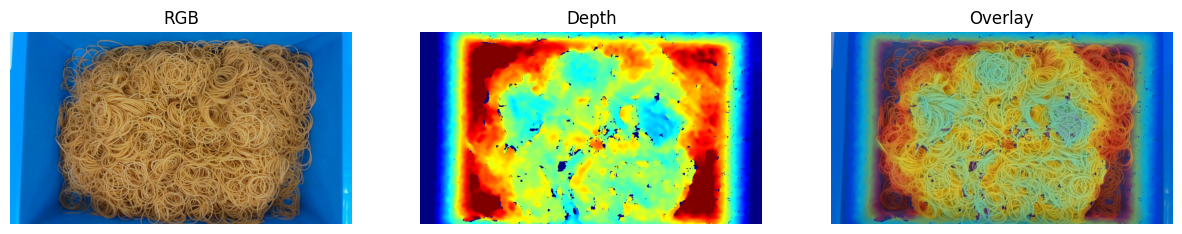

In [20]:
overlay, depth_cmap, near_used, far_used, saved = show_overlay_inline(
    rgb_path=Path("./data/rgb/2025-01-20T16-56-09.png"),
    depth_csv_path=Path("./data/csv_depth/2025-01-20T16-56-09.csv"),
    alpha=0.4,          # 重ね具合
    near=None, far=None,# 自動推定。固定したければmで指定
    depth_scale=0.001,  # RealSense: uint16 -> m
    save_dir=None
    #save_dir=Path("./data")  # 保存したくなければ None
)

#print("near/far used:", near_used, far_used)
#print(saved)

True True


/tmp/ipykernel_141289/2653628799.py:205: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("jet")


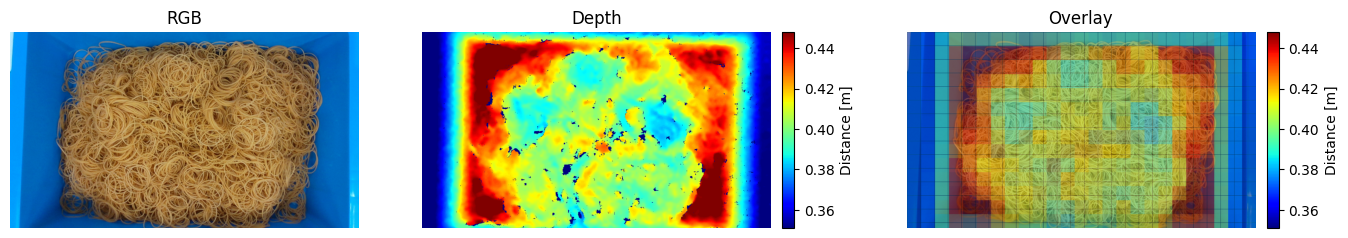

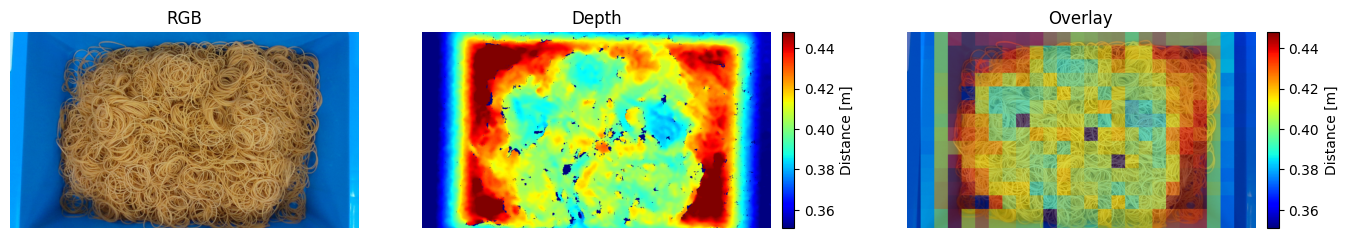

In [ ]:
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
import numpy as np


def load_depth_csv(path: Path, depth_scale: float = 0.001) -> np.ndarray:
    """
    CSV形式の深度画像を読み込み，[m]単位に変換して返す。

    depth_scale:
        RealSense の uint16[mm] → [m] なら 0.001
    """
    d = np.loadtxt(path, delimiter=",").astype(np.float32)
    d[d <= 0] = np.nan  # 0以下は無効値として NaN
    return d * depth_scale


def depth_to_colormap(
    depth_m: np.ndarray,
    near: float | None = None,
    far: float | None = None,
):
    """
    深度[m]画像を JET カラーマップの BGR 画像に変換する。

    near / far が None の場合は有効画素の 5〜95 パーセンタイルから自動推定。
    """
    valid = depth_m[np.isfinite(depth_m)]

    if near is None or far is None:
        if valid.size == 0:
            near, far = 0.2, 1.0
        else:
            near = float(np.percentile(valid, 5))
            far = float(np.percentile(valid, 95))
            if near == far:
                near, far = max(near - 0.05, 0.05), near + 0.05

    x = np.clip((depth_m - near) / (far - near), 0, 1)
    vis = (x * 255).astype(np.uint8)

    depth_cmap = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
    return depth_cmap, near, far


def to_mesh_style(
    depth_cmap: np.ndarray,
    cell: int = 16,
    line_thickness: int = 1,
) -> np.ndarray:
    """
    深度ヒートマップを「メッシュ調」に見えるように加工する。

    - cell: 1マスのサイズ（大きいほど荒いメッシュ）
    - line_thickness: 格子線の太さ（0 なら線なしでブロック状だけ）
    """
    h, w = depth_cmap.shape[:2]

    # ① 粗いグリッドにリサイズしてブロック状に
    small_w = max(1, w // cell)
    small_h = max(1, h // cell)

    small = cv2.resize(depth_cmap, (small_w, small_h), interpolation=cv2.INTER_AREA)
    blocky = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)

    # ② 格子線を描画
    mesh = blocky.copy()
    line_color = (0, 0, 0)  # 黒線

    if line_thickness > 0:
        # 横線
        for y in range(0, h, cell):
            cv2.line(mesh, (0, y), (w, y), line_color, thickness=line_thickness)
        # 縦線
        for x in range(0, w, cell):
            cv2.line(mesh, (x, 0), (x, h), line_color, thickness=line_thickness)

    return mesh


def to_sparse_style(
    depth_cmap: np.ndarray,
    step: int = 16,
    point_size: int = 1,
) -> np.ndarray:
    """
    深度ヒートマップを「間引いた点」だけ表示するスタイルに変換する。

    step:
        何ピクセルごとに1点だけ表示するか（大きいほどスカスカ）
    point_size:
        各点の大きさ（半径）。1だと1ピクセル、2以上にすると小さな四角になる。
    """
    h, w = depth_cmap.shape[:2]
    # 何も塗られていない（= 重畳なし）画像からスタート（黒）
    sparse = np.zeros_like(depth_cmap)

    for y in range(0, h, step):
        for x in range(0, w, step):
            if point_size <= 1:
                # 1ピクセルだけ色をコピー
                sparse[y, x] = depth_cmap[y, x]
            else:
                # 小さなブロックとしてコピー
                y0 = max(0, y - point_size)
                y1 = min(h, y + point_size)
                x0 = max(0, x - point_size)
                x1 = min(w, x + point_size)
                sparse[y0:y1, x0:x1] = depth_cmap[y, x]

    return sparse

def show_overlay_inline(
    rgb_path: Path,
    depth_csv_path: Path,
    alpha: float = 1,
    near: float | None = None,
    far: float | None = None,
    depth_scale: float = 0.001,
    save_dir: Path | None = None,
    overlay_mode: str = "mesh",  # "mesh", "sparse", "plain"
    #use_mesh: bool = True,
    mesh_cell: int = 16,
    mesh_line_thickness: int = 1,
    sparse_step: int = 16,
    sparse_point_size: int = 2,
):
    """
    RGB ＋ 深度CSV を読み込み，ヒートマップとオーバーレイを表示＆保存する。

    use_mesh=True のとき，Overlay はメッシュ調ヒートマップを使用。
    真ん中の Depth パネルは従来通りのベタ塗りヒートマップ。
    """
    # --- RGB 読み込み（BGR） ---
    color = cv2.imread(str(rgb_path))
    if color is None:
        raise FileNotFoundError(f"Could not read RGB image: {rgb_path}")

    # --- 深度読み込み ---
    depth_m = load_depth_csv(depth_csv_path, depth_scale=depth_scale)

    if (color.shape[0], color.shape[1]) != depth_m.shape:
        raise ValueError(f"Size mismatch: RGB {color.shape[:2]} vs Depth {depth_m.shape}")

    # --- 深度 → ヒートマップ ---
    depth_cmap, near_used, far_used = depth_to_colormap(depth_m, near, far)

    # --- オーバーレイ用ヒートマップをモードで切り替え ---
    if overlay_mode == "mesh":
        depth_cmap_for_overlay = to_mesh_style(
            depth_cmap,
            cell=mesh_cell,
            line_thickness=mesh_line_thickness,
        )
    elif overlay_mode == "sparse":
        depth_cmap_for_overlay = to_sparse_style(
            depth_cmap,
            step=sparse_step,
            point_size=sparse_point_size,
        )
    else:  # "plain"
        depth_cmap_for_overlay = depth_cmap

    # --- αブレンド ---
    overlay = cv2.addWeighted(color, 1 - alpha, depth_cmap_for_overlay, alpha, 0)

    # ===== matplotlib で並べて表示（RGB 変換） =====
    color_rgb = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    depth_rgb = cv2.cvtColor(depth_cmap, cv2.COLOR_BGR2RGB)  # 中央パネルは通常ヒートマップ
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    fig = plt.figure(figsize=(17, 5))

    # 1行5列のグリッド
    # [RGB] [Depth] [Depth用バー] [Overlay] [Overlay用バー]
    gs = fig.add_gridspec(
        1, 5,
        width_ratios=[20, 20, 0.5, 20, 0.5], # 画像3枚は全部同じ幅
        wspace = 0.3
    )

    ax_rgb    = fig.add_subplot(gs[0, 0])
    ax_depth  = fig.add_subplot(gs[0, 1])
    ax_cbar_d = fig.add_subplot(gs[0, 2])
    ax_ov     = fig.add_subplot(gs[0, 3])
    ax_cbar_o = fig.add_subplot(gs[0, 4])

    # --- 画像表示 ---
    ax_rgb.imshow(color_rgb)
    ax_rgb.set_title("RGB")
    ax_rgb.axis("off")

    ax_depth.imshow(depth_rgb)
    ax_depth.set_title("Depth")
    ax_depth.axis("off")

    ax_ov.imshow(overlay_rgb)
    ax_ov.set_title("Overlay")
    ax_ov.axis("off")

    # --- 共通カラーマップ（Depth と Overlay で同じレンジ） ---
    cmap = plt.cm.get_cmap("jet")
    norm = mcolors.Normalize(vmin=near_used, vmax=far_used)

    # Depth 用カラーバー
    sm_d = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm_d.set_array([])
    cbar_d = fig.colorbar(sm_d, cax=ax_cbar_d)
    cbar_d.set_label("Distance [m]")

    # Overlay 用カラーバー
    sm_o = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm_o.set_array([])
    cbar_o = fig.colorbar(sm_o, cax=ax_cbar_o)
    cbar_o.set_label("Distance [m]")

    # Depth の軸の位置を基準に、Depth 用カラーバーの縦位置・高さを揃える
    pos_depth  = ax_depth.get_position()
    pos_cbar_d = ax_cbar_d.get_position()
    ax_cbar_d.set_position([pos_cbar_d.x0, pos_depth.y0,
                            pos_cbar_d.width, pos_depth.height])

    # Overlay も同様に
    pos_ov     = ax_ov.get_position()
    pos_cbar_o = ax_cbar_o.get_position()
    ax_cbar_o.set_position([pos_cbar_o.x0, pos_ov.y0,
                            pos_cbar_o.width, pos_ov.height])

    for ax_img, ax_cbar in [(ax_depth, ax_cbar_d), (ax_ov, ax_cbar_o)]:
        pos_img  = ax_img.get_position()

        gap       = 0.007  # 画像とバーのすき間
        bar_width = 0.007  # バーの太さ

        ax_cbar.set_position([
            pos_img.x1 + gap,   # x0: 画像の右端 + すき間
            pos_img.y0,         # y0: 画像の下端に合わせる
            bar_width,          # 幅: 細さをここで決める
            pos_img.height      # 高さ: 画像と同じに揃える
        ])

    plt.show()

    # ===== matplotlib 図を保存（RGB / Depth / Overlay + カラーバー付き） =====
    saved: dict[str, str] = {}
    if save_dir is not None:
        save_dir = Path(save_dir)
        (save_dir / "panel_matplotlib").mkdir(parents=True, exist_ok=True)

        stem = rgb_path.stem
        panel_fig_path = save_dir / "panel_matplotlib" / f"{stem}_panel.png"

        fig.savefig(panel_fig_path, dpi=200, bbox_inches="tight")
        saved["panel_matplotlib"] = str(panel_fig_path)

    return overlay, depth_cmap, near_used, far_used, saved


# ===== 動作確認用サンプル =====
if __name__ == "__main__":
    rgb_path = Path("./data/rgb/2025-01-20T16-56-09.png")
    depth_path = Path("./data/csv_depth/2025-01-20T16-56-09.csv")

    print(rgb_path.exists(), depth_path.exists())

    overlay, depth_cmap, near_used, far_used, saved = show_overlay_inline(
        rgb_path=rgb_path,
        depth_csv_path=depth_path,
        alpha=0.5,
        near=None,
        far=None,
        depth_scale=0.001,
        #save_dir=Path("."),
        mesh_cell= 50,
        mesh_line_thickness=1,
    )

    overlay, depth_cmap, near_used, far_used, saved = show_overlay_inline(
        rgb_path=rgb_path,
        depth_csv_path=depth_path,
        alpha=0.5,
        overlay_mode="sparse",
        sparse_step=50,        # 24ピクセルごとに1点
        sparse_point_size=50,   # 点を少しだけ大きく
        #save_dir=Path("."), 
    )

    #print("near/far used:", near_used, far_used)
    #print(saved)


In [21]:
def show_overlay_both(
    rgb_path: Path,
    depth_csv_path: Path,
    alpha: float = 0.5,
    near: float | None = None,
    far: float | None = None,
    depth_scale: float = 0.001,
    save_dir: Path | None = None,
    mesh_cell: int = 50,
    mesh_line_thickness: int = 1,
    sparse_step: int = 50,
    sparse_point_size: int = 50,
):
    """
    RGB / Depth / Overlay(mesh) / Overlay(sparse) を
    1枚の Figure に並べて保存する関数。
    """

    # ==== データ読み込み・共通処理 ====
    color = cv2.imread(str(rgb_path))
    if color is None:
        raise FileNotFoundError(f"Could not read RGB image: {rgb_path}")

    depth_m = load_depth_csv(depth_csv_path, depth_scale=depth_scale)
    if (color.shape[0], color.shape[1]) != depth_m.shape:
        raise ValueError(f"Size mismatch: RGB {color.shape[:2]} vs Depth {depth_m.shape}")

    # 深度 → ヒートマップ
    depth_cmap, near_used, far_used = depth_to_colormap(depth_m, near, far)

    # mesh 用オーバーレイ
    depth_cmap_mesh = to_mesh_style(
        depth_cmap, cell=mesh_cell, line_thickness=mesh_line_thickness
    )
    overlay_mesh = cv2.addWeighted(color, 1 - alpha, depth_cmap_mesh, alpha, 0)

    # sparse 用オーバーレイ
    depth_cmap_sparse = to_sparse_style(
        depth_cmap, step=sparse_step, point_size=sparse_point_size
    )
    overlay_sparse = cv2.addWeighted(color, 1 - alpha, depth_cmap_sparse, alpha, 0)

    # ==== matplotlib 表示用に RGB 変換 ====
    color_rgb   = cv2.cvtColor(color,          cv2.COLOR_BGR2RGB)
    depth_rgb   = cv2.cvtColor(depth_cmap,     cv2.COLOR_BGR2RGB)
    mesh_rgb    = cv2.cvtColor(overlay_mesh,   cv2.COLOR_BGR2RGB)
    sparse_rgb  = cv2.cvtColor(overlay_sparse, cv2.COLOR_BGR2RGB)

    fig = plt.figure(figsize=(20, 5))

    # [RGB] [Depth] [cbarD] [Overlay(mesh)] [cbarM] [Overlay(sparse)] [cbarS]
    gs = fig.add_gridspec(
        1, 7,
        width_ratios=[18, 18, 0.6, 18, 0.6, 18, 0.6],
        wspace=0.4,
    )

    ax_rgb    = fig.add_subplot(gs[0, 0])
    ax_depth  = fig.add_subplot(gs[0, 1])
    ax_cbar_d = fig.add_subplot(gs[0, 2])
    ax_mesh   = fig.add_subplot(gs[0, 3])
    ax_cbar_m = fig.add_subplot(gs[0, 4])
    ax_sparse = fig.add_subplot(gs[0, 5])
    ax_cbar_s = fig.add_subplot(gs[0, 6])

    # ---- 画像 ----
    ax_rgb.imshow(color_rgb);  ax_rgb.set_title("RGB");   ax_rgb.axis("off")
    ax_depth.imshow(depth_rgb); ax_depth.set_title("Depth"); ax_depth.axis("off")
    ax_mesh.imshow(mesh_rgb);  ax_mesh.set_title("Overlay (mesh)");  ax_mesh.axis("off")
    ax_sparse.imshow(sparse_rgb); ax_sparse.set_title("Overlay (sparse)"); ax_sparse.axis("off")

    # ---- 共通カラーマップ ----
    cmap = plt.cm.get_cmap("jet")
    norm = mcolors.Normalize(vmin=near_used, vmax=far_used)

    for ax_img, ax_cbar in [(ax_depth, ax_cbar_d),
                            (ax_mesh,  ax_cbar_m),
                            (ax_sparse, ax_cbar_s)]:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=ax_cbar)
        cbar.set_label("Distance [m]")

        # 画像とバーの高さを揃えつつ、間隔と太さを調整
        pos_img  = ax_img.get_position()
        gap       = 0.007
        bar_width = 0.007
        ax_cbar.set_position([
            pos_img.x1 + gap,
            pos_img.y0,
            bar_width,
            pos_img.height,
        ])

    plt.show()

    # ==== 保存 ====
    saved_path = None
    if save_dir is not None:
        save_dir = Path(save_dir)
        out_dir = save_dir / "panel_matplotlib"
        out_dir.mkdir(parents=True, exist_ok=True)

        stem = rgb_path.stem
        out_path = out_dir / f"{stem}_mesh_sparse_panel.png"

        fig.savefig(out_path, dpi=200, bbox_inches="tight")
        saved_path = str(out_path)

    return {
        "near": near_used,
        "far": far_used,
        "saved_panel": saved_path,
        "overlay_mesh": overlay_mesh,
        "overlay_sparse": overlay_sparse,
        "depth_cmap": depth_cmap,
    }


True True


/tmp/ipykernel_141289/365658018.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("jet")


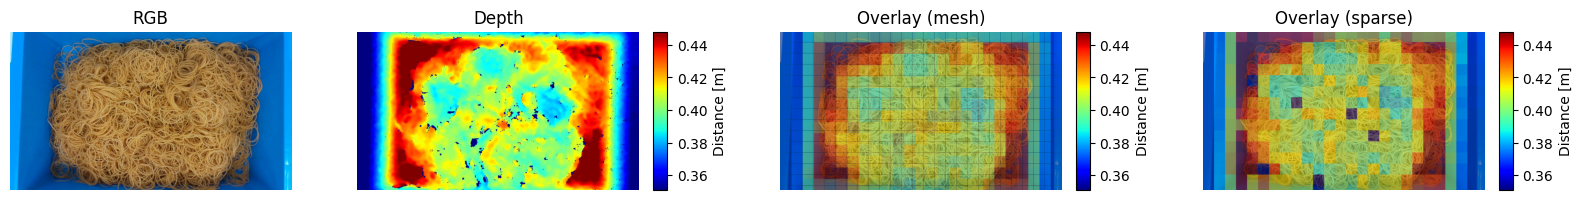

saved: panel_matplotlib/2025-01-20T16-56-09_mesh_sparse_panel.png


In [22]:
if __name__ == "__main__":
    rgb_path   = Path("./data/rgb/2025-01-20T16-56-09.png")
    depth_path = Path("./data/csv_depth/2025-01-20T16-56-09.csv")

    print(rgb_path.exists(), depth_path.exists())

    result = show_overlay_both(
        rgb_path=rgb_path,
        depth_csv_path=depth_path,
        alpha=0.5,
        mesh_cell=50,
        mesh_line_thickness=1,
        sparse_step=50,
        sparse_point_size=50,
        save_dir=Path("."),   # ← overlay.ipynb と同じフォルダ配下に保存
    )
    print("saved:", result["saved_panel"])
